In [54]:

import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
import  eda_helper_functions as e
from sklearn.ensemble import IsolationForest
import missingno as msno




# Read the trianing data 



In [10]:
file_path=r"C:\Users\USER\Desktop\sagemaker2\data\train.csv"
train = pd.read_csv(file_path)
train

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Air India,2019-03-24,Chennai,Kolkata,11:40:00,13:55:00,135,0.0,No Info,4405
1,Indigo,2019-06-27,Banglore,Delhi,22:10:00,01:00:00,170,0.0,No Info,3419
2,Indigo,2019-05-18,Kolkata,Banglore,08:10:00,13:00:00,290,1.0,No Info,5279
3,Indigo,2019-06-06,Delhi,Cochin,06:50:00,22:30:00,940,1.0,No Info,6674
4,Jet Airways,2019-05-27,Delhi,Cochin,11:30:00,12:35:00,1505,1.0,In-flight meal not included,12898
...,...,...,...,...,...,...,...,...,...,...
635,Jet Airways,2019-04-06,Delhi,Cochin,14:00:00,19:00:00,300,1.0,In-flight meal not included,5177
636,Air India,2019-03-27,Mumbai,Hyderabad,06:20:00,07:40:00,80,0.0,No Info,2575
637,Jet Airways,2019-03-21,Delhi,Cochin,19:10:00,18:50:00,1420,2.0,No Info,10929
638,Vistara,2019-04-09,Delhi,Cochin,06:00:00,09:10:00,190,0.0,No Info,5586


In [11]:
train.dtypes

airline             object
date_of_journey     object
source              object
destination         object
dep_time            object
arrival_time        object
duration             int64
total_stops        float64
additional_info     object
price                int64
dtype: object

In [18]:
train =train.assign(
    **{
        col:pd.to_datetime(train.loc[:,col],dayfirst=True,format ="mixed")
        for col in ["date_of_journey","dep_time","arrival_time"]
    }
)

train.dtypes

airline                    object
date_of_journey    datetime64[ns]
source                     object
destination                object
dep_time           datetime64[ns]
arrival_time       datetime64[ns]
duration                    int64
total_stops               float64
additional_info            object
price                       int64
dtype: object

In [19]:
train.head()

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Air India,2019-03-24,Chennai,Kolkata,2024-05-07 11:40:00,2024-05-07 13:55:00,135,0.0,No Info,4405
1,Indigo,2019-06-27,Banglore,Delhi,2024-05-07 22:10:00,2024-05-07 01:00:00,170,0.0,No Info,3419
2,Indigo,2019-05-18,Kolkata,Banglore,2024-05-07 08:10:00,2024-05-07 13:00:00,290,1.0,No Info,5279
3,Indigo,2019-06-06,Delhi,Cochin,2024-05-07 06:50:00,2024-05-07 22:30:00,940,1.0,No Info,6674
4,Jet Airways,2019-05-27,Delhi,Cochin,2024-05-07 11:30:00,2024-05-07 12:35:00,1505,1.0,In-flight meal not included,12898


# high level summary

In [20]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   airline          640 non-null    object        
 1   date_of_journey  640 non-null    datetime64[ns]
 2   source           640 non-null    object        
 3   destination      640 non-null    object        
 4   dep_time         640 non-null    datetime64[ns]
 5   arrival_time     640 non-null    datetime64[ns]
 6   duration         640 non-null    int64         
 7   total_stops      640 non-null    float64       
 8   additional_info  640 non-null    object        
 9   price            640 non-null    int64         
dtypes: datetime64[ns](3), float64(1), int64(2), object(4)
memory usage: 50.1+ KB


In [22]:
train.describe(include="number")

,duration,total_stops,price
count,640.000000,640.000000,640.000000
mean,632.453125,0.806250,9012.085938
std,495.511621,0.640294,4403.557334
min,75.000000,0.000000,1965.000000
25%,175.000000,0.000000,5403.000000
50%,510.000000,1.000000,8327.000000
75%,920.000000,1.000000,12252.500000
max,2525.000000,3.000000,31825.000000


In [23]:
train.describe(include="O")

,airline,source,destination,additional_info
count,640,640,640,640
unique,8,5,6,4
top,Jet Airways,Delhi,Cochin,No Info
freq,211,284,284,512


In [27]:
(
  train 
    .assign(total_stops =train["total_stops"].astype(object))
    .describe(include="O")
    
)

,airline,source,destination,total_stops,additional_info
count,640,640,640,640.0,640
unique,8,5,6,4.0,4
top,Jet Airways,Delhi,Cochin,1.0,No Info
freq,211,284,284,357.0,512


- Jet airways is the popular one
- Delhi to Cochin  is the boooked most
- flight with one stop is most famous 

## High level analysis of MIsssing values

In [29]:
e.missing_info(train)

,count,percentage
variable,,


In [35]:
forest = IsolationForest(n_estimators=10,random_state =42)

In [39]:
(
    train
    
    .assign(outlier=forest.fit_predict(train
                                       .drop(columns="price")
                                       .select_dtypes(include="number")))
)

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price,outlier
0,Air India,2019-03-24,Chennai,Kolkata,2024-05-07 11:40:00,2024-05-07 13:55:00,135,0.0,No Info,4405,-1
1,Indigo,2019-06-27,Banglore,Delhi,2024-05-07 22:10:00,2024-05-07 01:00:00,170,0.0,No Info,3419,1
2,Indigo,2019-05-18,Kolkata,Banglore,2024-05-07 08:10:00,2024-05-07 13:00:00,290,1.0,No Info,5279,1
3,Indigo,2019-06-06,Delhi,Cochin,2024-05-07 06:50:00,2024-05-07 22:30:00,940,1.0,No Info,6674,1
4,Jet Airways,2019-05-27,Delhi,Cochin,2024-05-07 11:30:00,2024-05-07 12:35:00,1505,1.0,In-flight meal not included,12898,-1
...,...,...,...,...,...,...,...,...,...,...,...
635,Jet Airways,2019-04-06,Delhi,Cochin,2024-05-07 14:00:00,2024-05-07 19:00:00,300,1.0,In-flight meal not included,5177,1
636,Air India,2019-03-27,Mumbai,Hyderabad,2024-05-07 06:20:00,2024-05-07 07:40:00,80,0.0,No Info,2575,-1
637,Jet Airways,2019-03-21,Delhi,Cochin,2024-05-07 19:10:00,2024-05-07 18:50:00,1420,2.0,No Info,10929,-1
638,Vistara,2019-04-09,Delhi,Cochin,2024-05-07 06:00:00,2024-05-07 09:10:00,190,0.0,No Info,5586,-1


In [46]:
(
    train
    
    .assign(outlier=forest.fit_predict(train
                                       .drop(columns="price")
                                       .select_dtypes(include="number")))
     .query("outlier == -1")  # filterate dataframe getting  outlier
     #.duration
     #.describe()  #chek if that is genuine outlier or not 
)

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price,outlier
0,Air India,2019-03-24,Chennai,Kolkata,2024-05-07 11:40:00,2024-05-07 13:55:00,135,0.0,No Info,4405,-1
4,Jet Airways,2019-05-27,Delhi,Cochin,2024-05-07 11:30:00,2024-05-07 12:35:00,1505,1.0,In-flight meal not included,12898,-1
6,Spicejet,2019-03-27,Chennai,Kolkata,2024-05-07 08:20:00,2024-05-07 10:35:00,135,0.0,No check-in baggage included,3332,-1
7,Jet Airways,2019-03-24,Kolkata,Banglore,2024-05-07 13:55:00,2024-05-07 16:20:00,1585,1.0,In-flight meal not included,10031,-1
10,Air India,2019-05-09,Kolkata,Banglore,2024-05-07 10:00:00,2024-05-07 05:25:00,1165,2.0,No Info,14424,-1
...,...,...,...,...,...,...,...,...,...,...,...
629,Spicejet,2019-06-06,Chennai,Kolkata,2024-05-07 09:45:00,2024-05-07 12:00:00,135,0.0,No check-in baggage included,3543,-1
630,Jet Airways,2019-04-21,Delhi,Cochin,2024-05-07 11:00:00,2024-05-07 14:15:00,195,0.0,In-flight meal not included,7202,-1
636,Air India,2019-03-27,Mumbai,Hyderabad,2024-05-07 06:20:00,2024-05-07 07:40:00,80,0.0,No Info,2575,-1
637,Jet Airways,2019-03-21,Delhi,Cochin,2024-05-07 19:10:00,2024-05-07 18:50:00,1420,2.0,No Info,10929,-1


### Pairplots
-  for numericals dtype

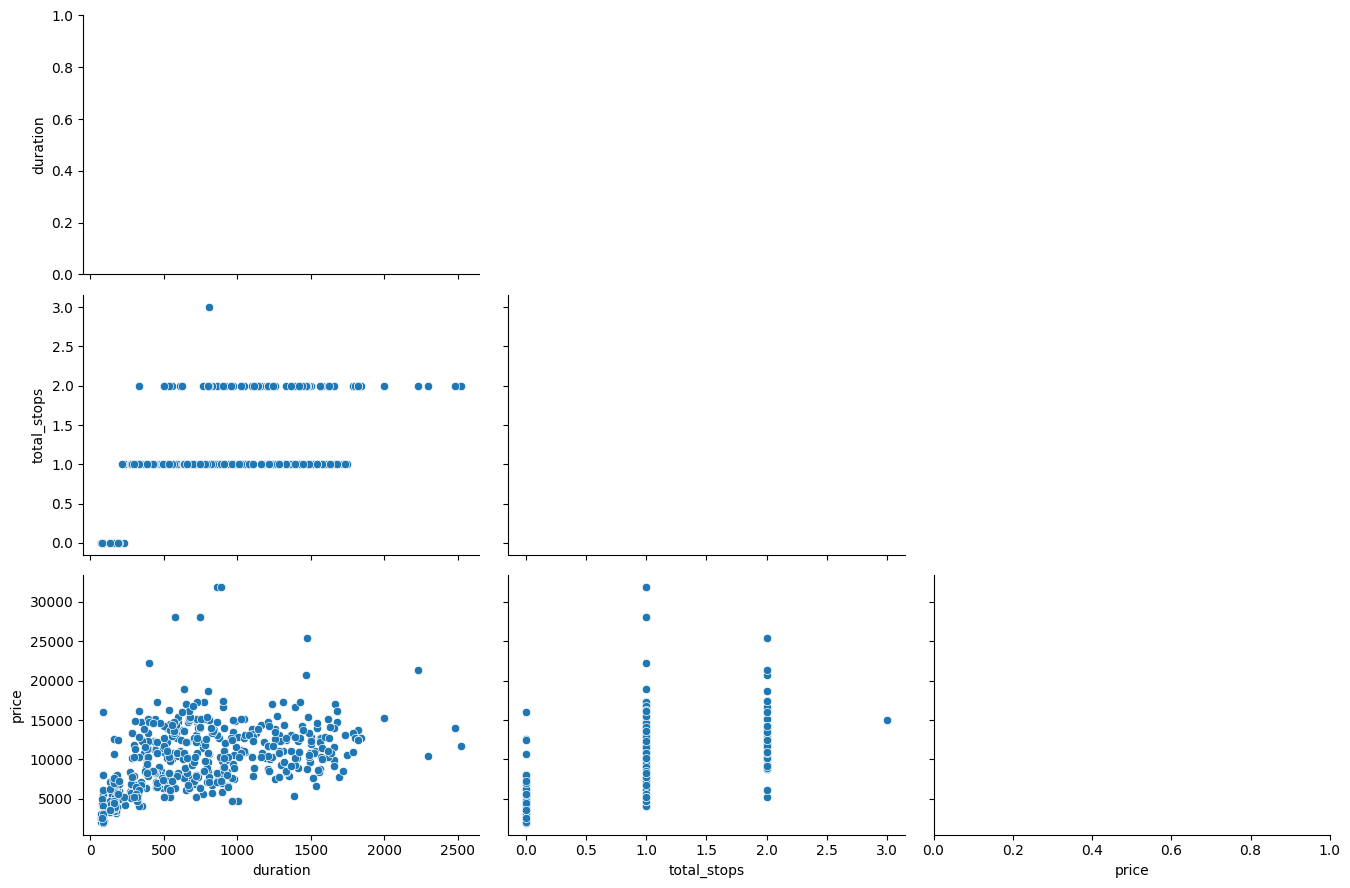

In [47]:
e.pair_plots(train)

## corelation Analysis

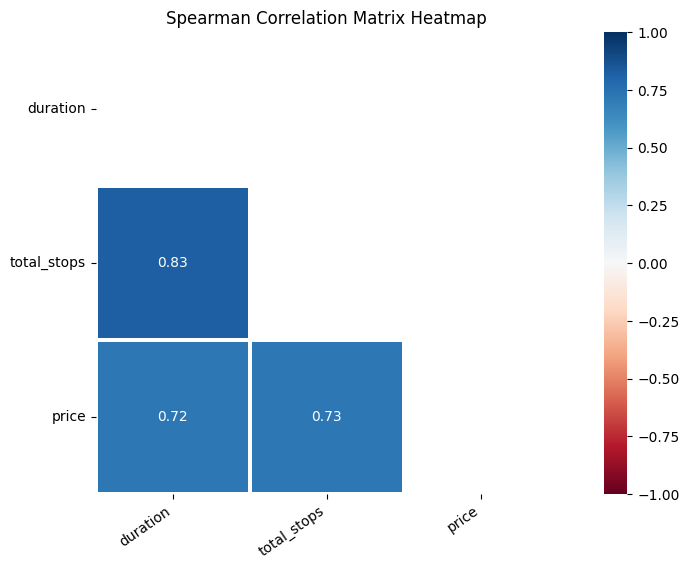

In [48]:
e.correlation_heatmap(train)

In [52]:
train.corr(method ="spearman",numeric_only=True)

,duration,total_stops,price
duration,1.000000,0.826858,0.720695
total_stops,0.826858,1.000000,0.725253
price,0.720695,0.725253,1.000000


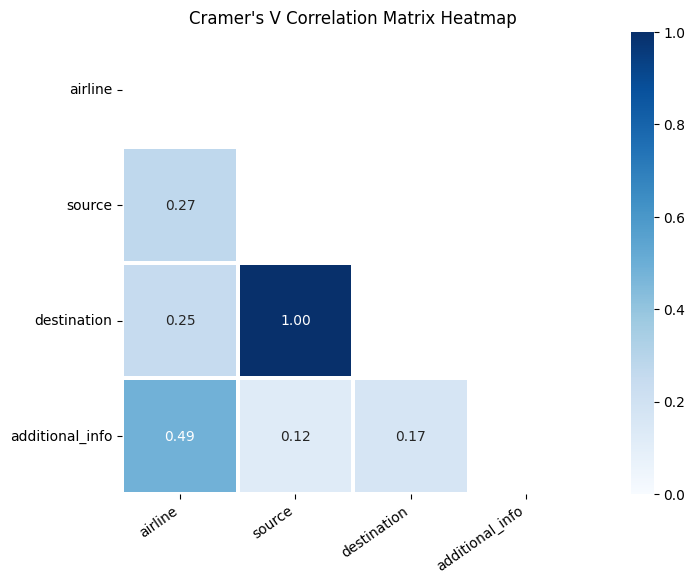

In [53]:
e.cramersV_heatmap(train)

## Detailed Analysis


In [55]:
train.columns

Index(['airline', 'date_of_journey', 'source', 'destination', 'dep_time',
       'arrival_time', 'duration', 'total_stops', 'additional_info', 'price'],
      dtype='object')

#### airline 

In [56]:
train.airline

0              Air India
1                 Indigo
2                 Indigo
3                 Indigo
4            Jet Airways
             ...        
635          Jet Airways
636            Air India
637          Jet Airways
638              Vistara
639    Multiple Carriers
Name: airline, Length: 640, dtype: object

In [57]:
e.cat_summary(train,"airline")

0              Air India
1                 Indigo
2                 Indigo
3                 Indigo
4            Jet Airways
             ...        
635          Jet Airways
636            Air India
637          Jet Airways
638              Vistara
639    Multiple Carriers
Name: airline, Length: 640, dtype: object

Data Type      : object
Cardinality    : 8 categories
Missing Data   : 0 rows (0.00 %)
Available Data : 640 / 640 rows


,
count,640
unique,8
top,Jet Airways
freq,211


,count,percentage
category,,
Jet Airways,211,0.329688
Indigo,127,0.198437
Air India,125,0.195312
Multiple Carriers,91,0.142187
Spicejet,39,0.060937
Vistara,19,0.029687
Air Asia,16,0.025000
Goair,12,0.018750


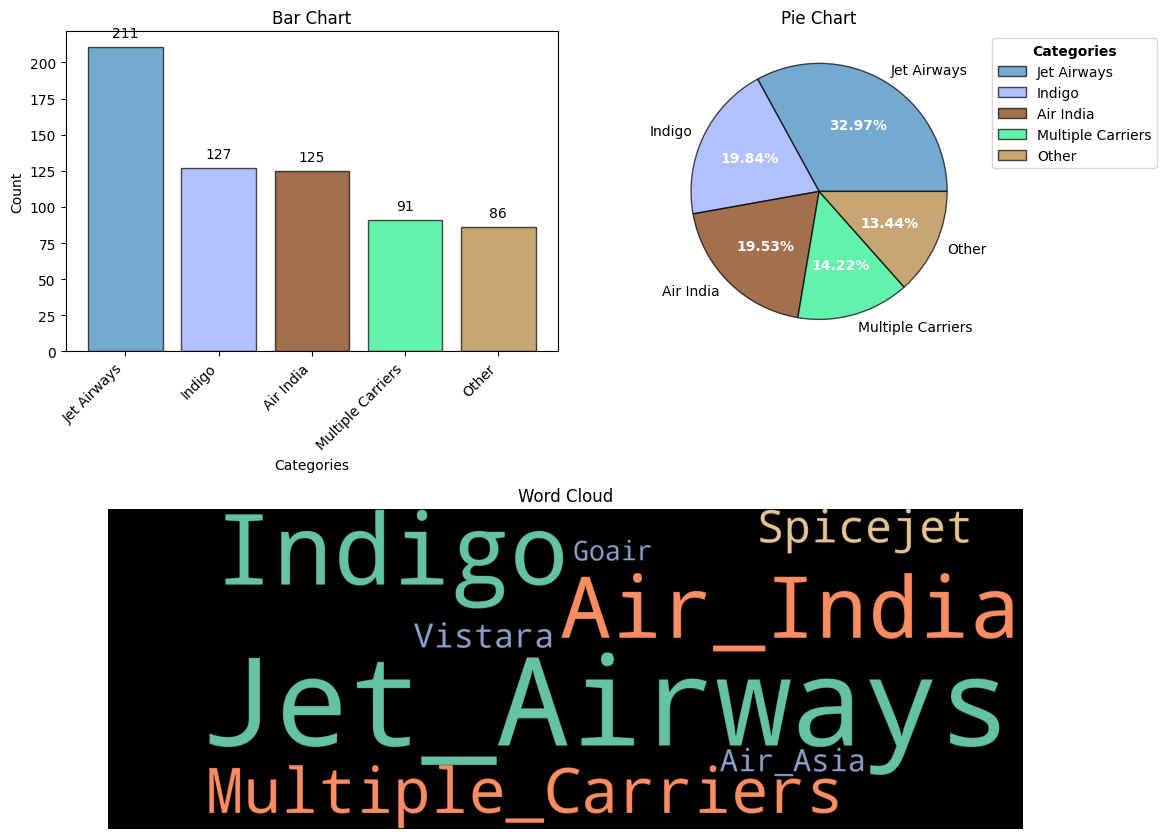

In [59]:
e.cat_univar_plots(train,"airline")

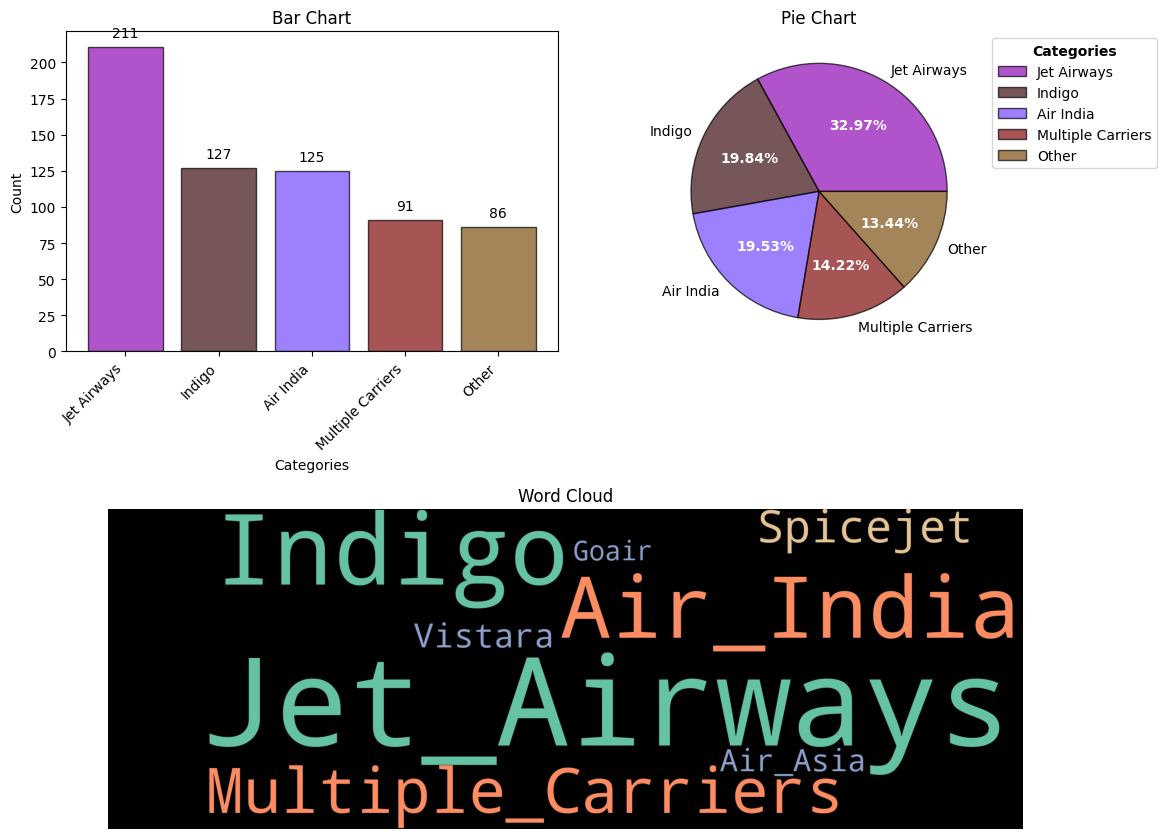

In [60]:
e.cat_univar_plots(train,"airline",k=4)

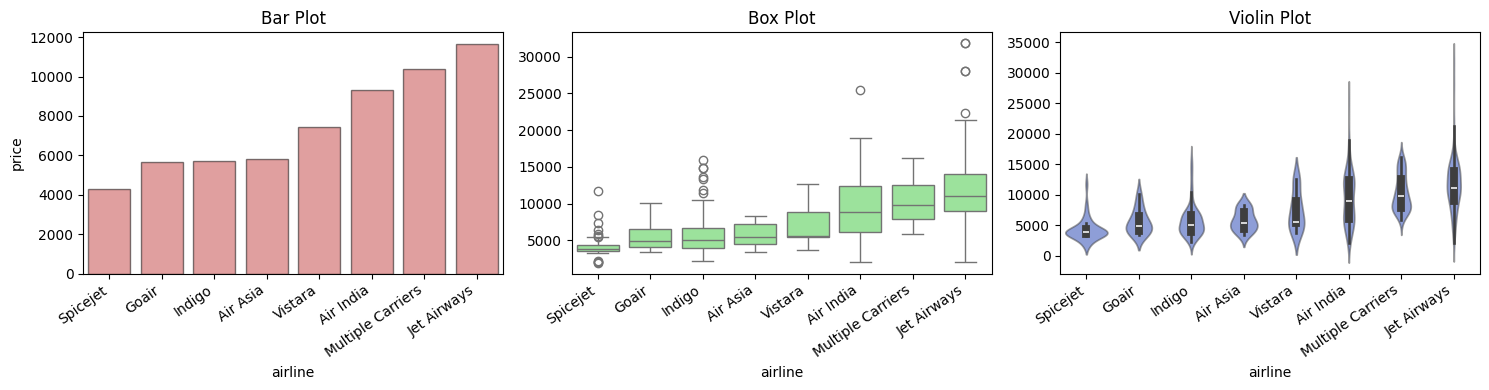

In [62]:
e.num_cat_bivar_plots(
    data= train,
    num_var="price",
    cat_var="airline"
)

In [63]:
# based on ailine  price is varing 

In [64]:
e.num_cat_hyp_testing(train, "price","airline")

- Significance Level   : 5.0%
- Null Hypothesis      : The groups have similar population mean
- Alternate Hypothesis : The groups don't have similar population mean
- Test Statistic       : 46.97553218917089
- p-value              : 1.220407061889072e-53
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and airline are associated to each other


- Significance Level   : 5.0%
- Null Hypothesis      : The groups have similar population median
- Alternate Hypothesis : The groups don't have similar population median
- Test Statistic       : 256.57573773359593
- p-value              : 1.103198157052091e-51
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and airline are associated to each other


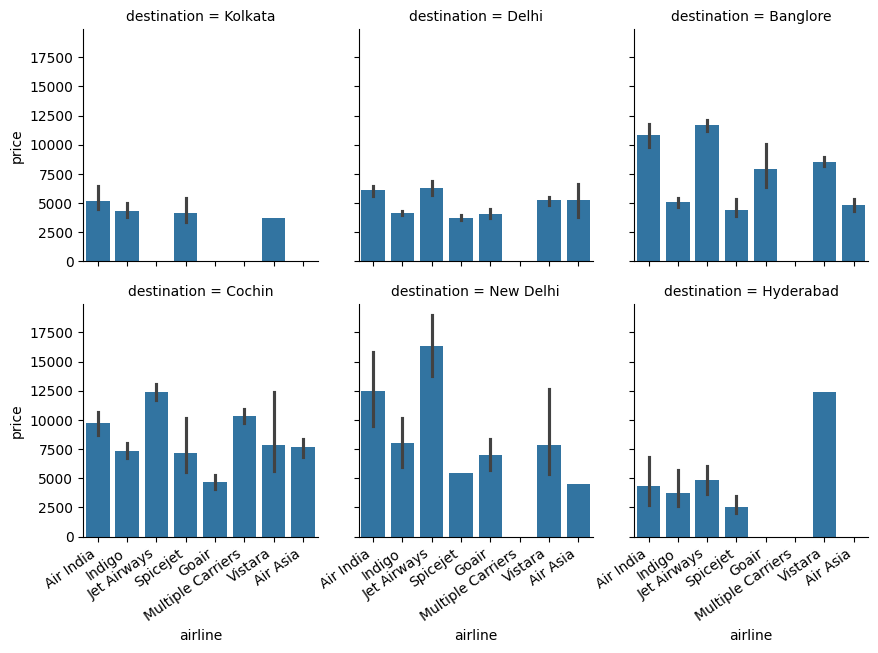

In [71]:
airline_grid =sns.FacetGrid(
    data = train,
    col="destination",
    col_wrap=3,
    sharey = True
)
airline_grid.map(sns.barplot,"airline","price",order=train.airline.unique())
airline_grid.axes

for ax in airline_grid.axes[3:]:
    e.rotate_xlabels(ax)
    

### Date OF Journey

In [74]:
train.date_of_journey 

0     2019-03-24
1     2019-06-27
2     2019-05-18
3     2019-06-06
4     2019-05-27
         ...    
635   2019-04-06
636   2019-03-27
637   2019-03-21
638   2019-04-09
639   2019-05-18
Name: date_of_journey, Length: 640, dtype: datetime64[ns]

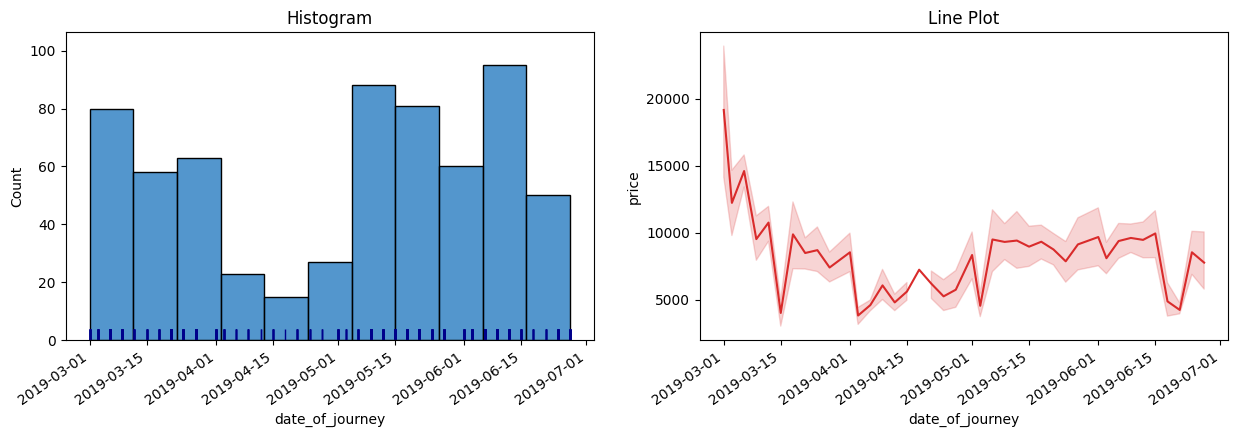

In [75]:
e.dt_univar_plots(
    data=train,
    var="date_of_journey",
    target ="price"
)

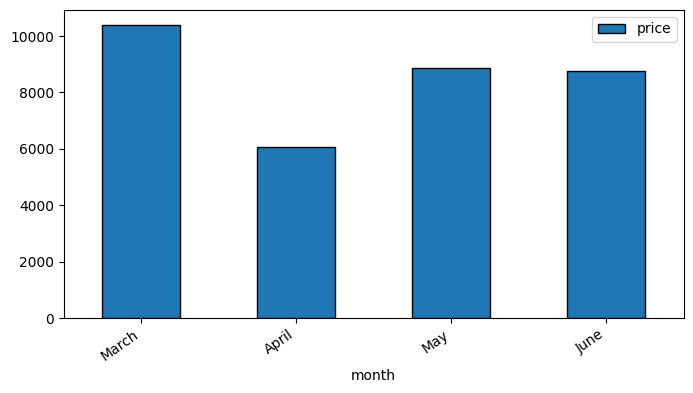

In [79]:
(
    train
    .groupby(pd.Grouper(key = "date_of_journey" ,freq ="M"))
    .price.mean()
    .to_frame()
    .set_axis(["March","April","May","June"],axis =0)
    .rename_axis(index= "month")
    .plot(
        kind="bar",
        figsize=(8,4),
        edgecolor ="black"
        
    )
)


ax = plt.gca()
e.rotate_xlabels(ax)

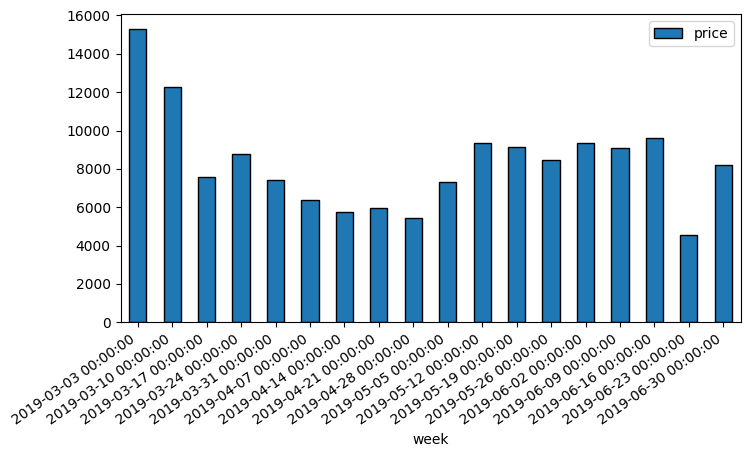

In [81]:
(
    train
    .groupby(pd.Grouper(key = "date_of_journey" ,freq ="W"))
    .price.mean()
    .to_frame()
    #.set_axis(["March","April","May","June"],axis =0)
    .rename_axis(index= "week")
    .plot(
        kind="bar",
        figsize=(8,4),
        edgecolor ="black"
        
    )
)


ax = plt.gca()
e.rotate_xlabels(ax)

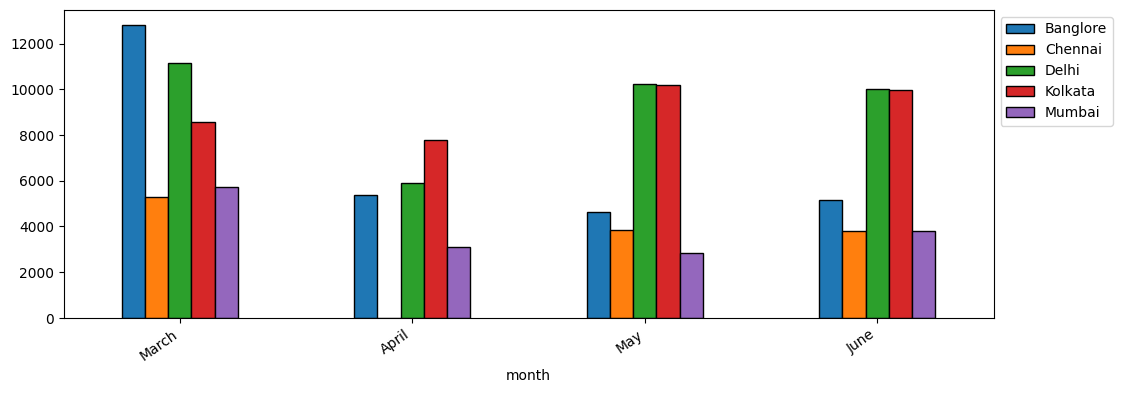

In [87]:
(
    train
    .groupby([pd.Grouper(key="date_of_journey",freq ="M"),"source"])
    .price.mean()
    .unstack(fill_value=0)
    .set_axis(["March","April","May","June"],axis=0)
    .rename_axis(index ="month")
    .plot(
        kind="bar",
        figsize =(12,4),
        edgecolor="black"
   
    )

)

ax=plt.gca()
ax.legend(
    loc ="upper left",
    bbox_to_anchor =(1,1)
)
e.rotate_xlabels(ax)

## dep_time


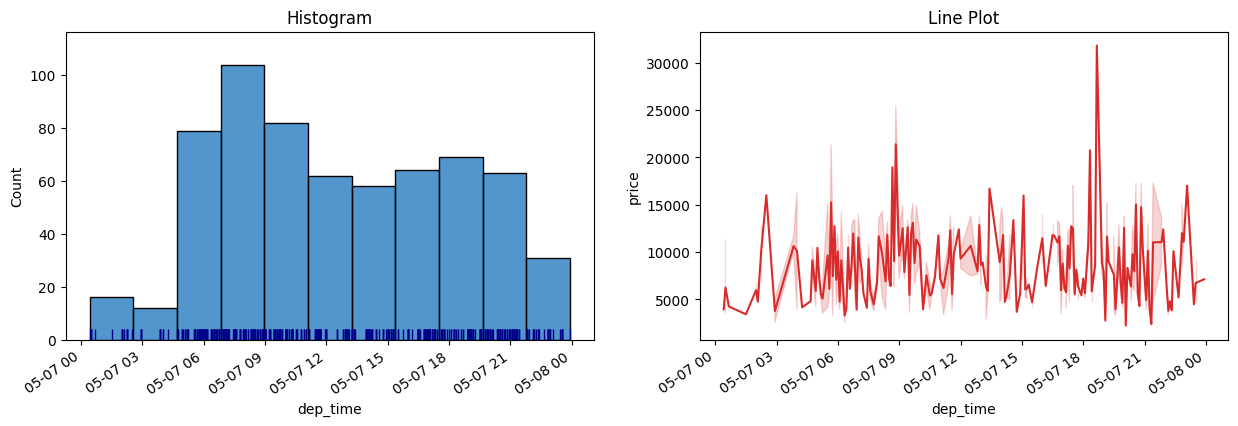

In [89]:
e.dt_univar_plots(
        data = train,
        var = "dep_time",
        target="price"
        
         
)

In [92]:
(
    train
    .dep_time
    .dt.hour
    .pipe(lambda ser:ser)
)

0      11
1      22
2       8
3       6
4      11
       ..
635    14
636     6
637    19
638     6
639     8
Name: dep_time, Length: 640, dtype: int32

In [100]:
(
    train
    .dep_time
    .dt.hour
    .pipe(lambda ser:pd.Series(np.select([ser.between(4,12,   inclusive ="left"),
                                           ser.between(12,16,   inclusive ="left"),
                                            ser.between(16,20,  inclusive ="left")],
                             
                               ["morning","afternoon","evening"],
                              
                               default="night")))
)

0        morning
1          night
2        morning
3        morning
4        morning
         ...    
635    afternoon
636      morning
637      evening
638      morning
639      morning
Length: 640, dtype: object

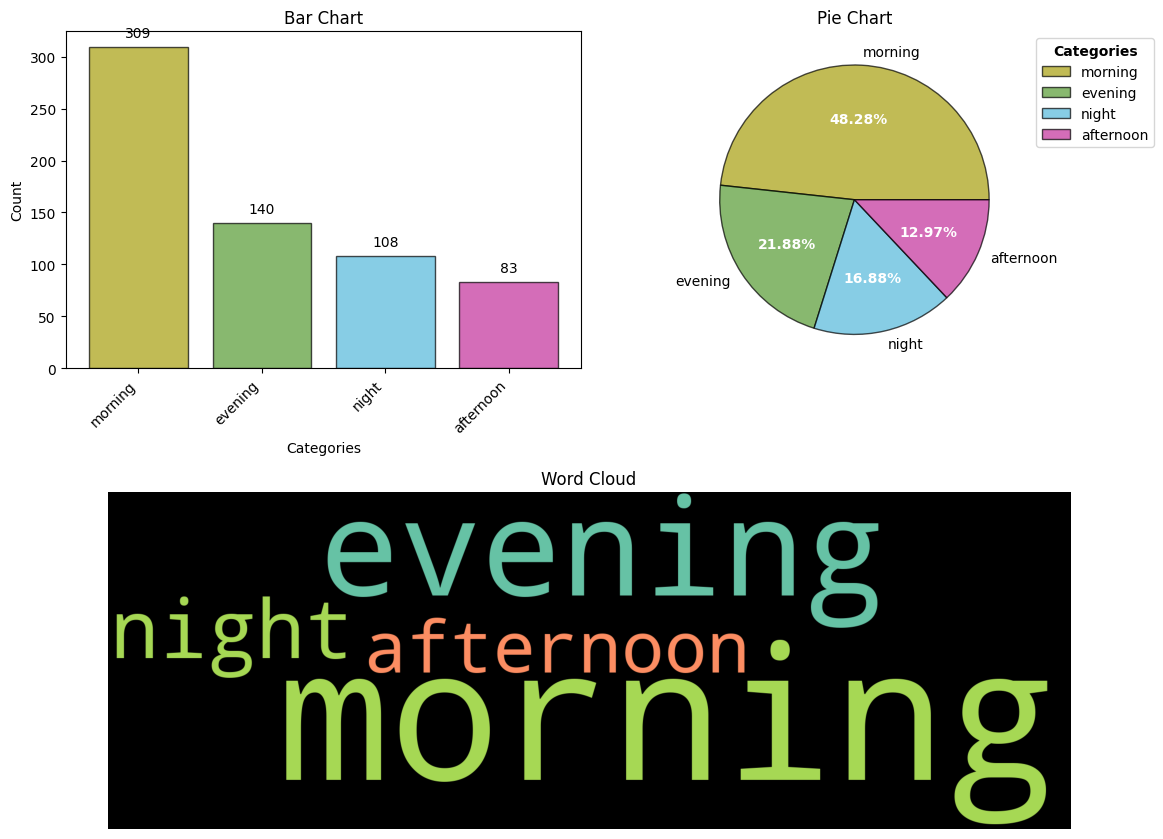

In [104]:


(
    train
    .assign(dep_time=lambda df_:(np.select([df_.dep_time.dt.hour.between(4,12,   inclusive ="left"),
                                           df_.dep_time.dt.hour.between(12,16,   inclusive ="left"),
                                            df_.dep_time.dt.hour.between(16,20,  inclusive ="left")],
                             
                               ["morning","afternoon","evening"],
                              
                               default="night")))
    .pipe(e.cat_univar_plots,"dep_time")
)

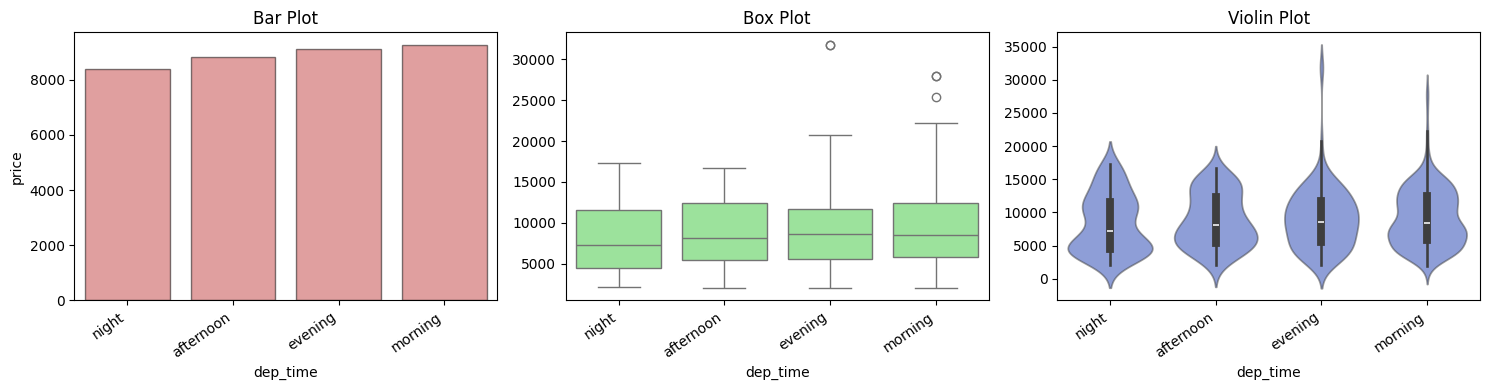

In [105]:
(
    train
    .assign(dep_time=lambda df_:(np.select([df_.dep_time.dt.hour.between(4,12,   inclusive ="left"),
                                           df_.dep_time.dt.hour.between(12,16,   inclusive ="left"),
                                            df_.dep_time.dt.hour.between(16,20,  inclusive ="left")],
                             
                               ["morning","afternoon","evening"],
                              
                               default="night")))
    .pipe(e.num_cat_bivar_plots,"price","dep_time")
)

## duyration